In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import keras_tuner as kt

# Step 1: Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data to be in the form (batch_size, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Step 2: Define the model with hyperparameters for tuning
def build_model(hp):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=96, step=32), 
                            kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1),
                            kernel_regularizer=regularizers.l2(hp.Float('conv_1_l2', min_value=0.0, max_value=0.05, step=0.01))))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(filters=hp.Int('conv_2_filters', min_value=64, max_value=192, step=64), 
                            kernel_size=(3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(hp.Float('conv_2_l2', min_value=0.0, max_value=0.05, step=0.01))))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=128, max_value=384, step=128),
                           activation='relu', kernel_regularizer=regularizers.l2(hp.Float('dense_1_l2', min_value=0.0, max_value=0.05, step=0.01))))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))

    # Fully Connected Layer 2
    model.add(layers.Dense(units=hp.Int('dense_2_units', min_value=64, max_value=192, step=64),
                           activation='relu', kernel_regularizer=regularizers.l2(hp.Float('dense_2_l2', min_value=0.0, max_value=0.05, step=0.01))))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Step 3: Set up the Hyperparameter Tuner with reduced trials
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=3,           # Fewer epochs
                     hyperband_iterations=1, # Fewer iterations
                     directory='my_dir',
                     project_name='mnist_tuning_reduced_trials')

# Step 4: Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Step 5: Start the Hyperparameter Search
tuner.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Step 6: Get the Best Model and Hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Step 7: Evaluate the Best Model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Step 8: Plot Training and Validation Accuracy & Loss

# Get the training history
history = best_model.history.history


Reloading Tuner from my_dir/mnist_tuning_reduced_trials/tuner0.json
Best Hyperparameters: {'conv_1_filters': 64, 'conv_1_l2': 0.04, 'conv_2_filters': 64, 'conv_2_l2': 0.0, 'dense_1_units': 384, 'dense_1_l2': 0.01, 'dropout_1': 0.3, 'dense_2_units': 192, 'dense_2_l2': 0.0, 'dropout_2': 0.4, 'learning_rate': 0.0006651256099971132, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
313/313 - 1s - 4ms/step - accuracy: 0.9797 - loss: 0.1844
Test accuracy: 0.9797000288963318


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9701 - loss: 0.2095 - val_accuracy: 0.9763 - val_loss: 0.1888
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9733 - loss: 0.2029 - val_accuracy: 0.9753 - val_loss: 0.1830
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9752 - loss: 0.1926 - val_accuracy: 0.9810 - val_loss: 0.1645
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9748 - loss: 0.1926 - val_accuracy: 0.9860 - val_loss: 0.1554
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9754 - loss: 0.1837 - val_accuracy: 0.9844 - val_loss: 0.1533


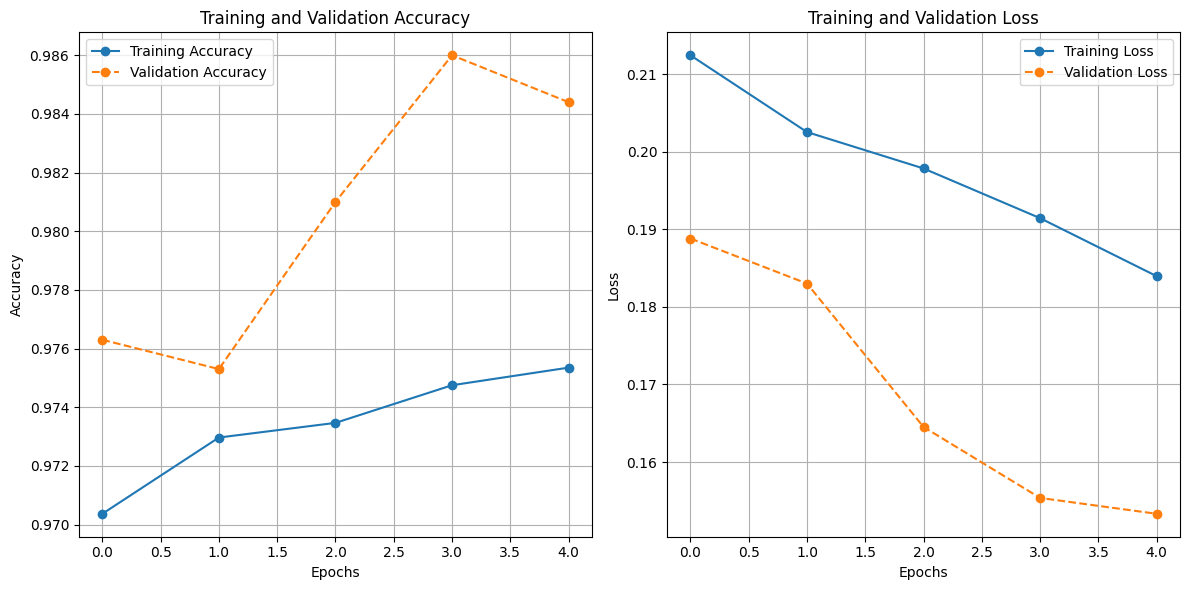

In [13]:
# Retrain the best model to capture training history
retrain_history = best_model.fit(
    x_train, y_train,
    epochs=5,  # Adjust epochs as needed
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Retrieve the training history
history = retrain_history.history

# Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12, 6))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
